In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
df = spark.read.csv('train.csv', inferSchema=True, header =True)

# Data Understanding

In [3]:
print((df.count(), len(df.columns)))

(1460, 81)


In [4]:
df.limit(10).toPandas()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [5]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [6]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
data = pd.read_csv("train.csv")

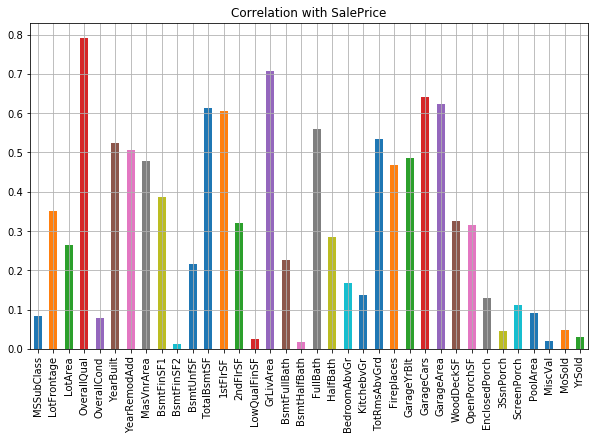

In [7]:
correl = data[1:].corr()
correl.drop(["SalePrice", "Id"], axis=1, inplace=True)

correl.iloc[-1].apply(lambda x: abs(x)).plot(kind='bar', figsize=(10, 6), title="Correlation with SalePrice", grid=True)

In [8]:
salecorrel = pd.DataFrame(correl.transpose()["SalePrice"])
top_features = salecorrel[salecorrel["SalePrice"] >= 0.45].sort_values(by=["SalePrice"], 
                                                                      ascending=False)
topcolumns = top_features.transpose().columns.values
topcorrelVal = top_features.values

["{0}: {1:.4f}".format(col, topcorrelVal[i][0]) for i,col in enumerate(topcolumns)]

['OverallQual: 0.7910',
 'GrLivArea: 0.7086',
 'GarageCars: 0.6404',
 'GarageArea: 0.6234',
 'TotalBsmtSF: 0.6138',
 '1stFlrSF: 0.6062',
 'FullBath: 0.5606',
 'TotRmsAbvGrd: 0.5337',
 'YearBuilt: 0.5229',
 'YearRemodAdd: 0.5070',
 'GarageYrBlt: 0.4863',
 'MasVnrArea: 0.4774',
 'Fireplaces: 0.4673']

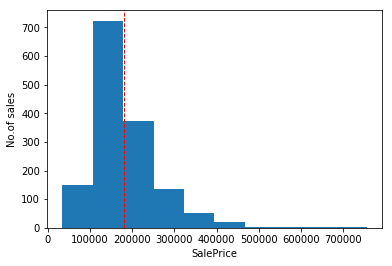

In [9]:
plt.hist(data["SalePrice"])
plt.xlabel("SalePrice")
plt.ylabel("No.of sales")
plt.axvline(data["SalePrice"].mean(),color='red', linestyle='dashed', linewidth=1)

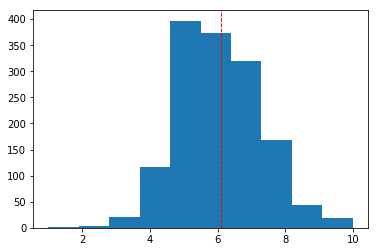

In [10]:
plt.hist(data["OverallQual"])
plt.axvline(data["OverallQual"].mean(),color='red', linestyle='dashed', linewidth=1)

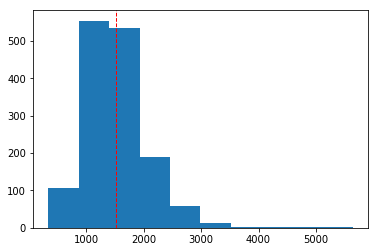

In [11]:
plt.hist(data["GrLivArea"])
plt.axvline(data["GrLivArea"].mean(),color='red', linestyle='dashed', linewidth=1)

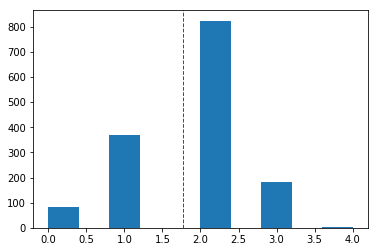

In [12]:
plt.hist(data["GarageCars"])
plt.axvline(data["GarageCars"].mean(),color='red', linestyle='dashed', linewidth=1)

In [13]:
import pyspark.sql.functions as F

from functools import reduce

df_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        df.agg(
            F.count(F.when(F.isnull(c), c)).alias('NULL_Count')
        ).select(F.lit(c).alias("Column_Name"), "NULL_Count")
        for c in df.columns
    )
)

df_agg_col.orderBy("NULL_Count",ascending=False).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|      PoolQC|      1453|
| MiscFeature|      1406|
|       Alley|      1369|
|       Fence|      1179|
| FireplaceQu|       690|
| LotFrontage|       259|
|  GarageCond|        81|
| GarageYrBlt|        81|
|GarageFinish|        81|
|  GarageQual|        81|
|  GarageType|        81|
|BsmtFinType2|        38|
|BsmtExposure|        38|
|    BsmtQual|        37|
|BsmtFinType1|        37|
|    BsmtCond|        37|
|  MasVnrArea|         8|
|  MasVnrType|         8|
|  Electrical|         1|
|  Condition1|         0|
+------------+----------+
only showing top 20 rows



# Data Preparation

In [14]:
columns_to_drop = ['PoolQC','MiscFeature', 'Alley', 'Fence']
df = df.drop(*columns_to_drop)

print((df.count(), len(df.columns)))

(1460, 77)


In [15]:
df_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        df.agg(
            F.count(F.when(F.isnull(c), c)).alias('NULL_Count')
        ).select(F.lit(c).alias("Column_Name"), "NULL_Count")
        for c in df.columns
    )
)

df_agg_col.orderBy("NULL_Count",ascending=False).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
| FireplaceQu|       690|
| LotFrontage|       259|
| GarageYrBlt|        81|
|GarageFinish|        81|
|  GarageQual|        81|
|  GarageType|        81|
|  GarageCond|        81|
|BsmtFinType2|        38|
|BsmtExposure|        38|
|    BsmtQual|        37|
|BsmtFinType1|        37|
|    BsmtCond|        37|
|  MasVnrArea|         8|
|  MasVnrType|         8|
|  Electrical|         1|
|      Street|         0|
|Neighborhood|         0|
|  Condition1|         0|
|    LotShape|         0|
|  Condition2|         0|
+------------+----------+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import mean

mean_LotFrontage = df.select(mean(df['LotFrontage'])).collect()

df = df.na.fill(mean_LotFrontage[0][0], subset=['LotFrontage'])

mean_GarageYrBlt = df.select(mean(df['GarageYrBlt'])).collect()

df = df.na.fill(mean_GarageYrBlt[0][0], subset=['GarageYrBlt'])

mean_MasVnrArea = df.select(mean(df['MasVnrArea'])).collect()

df = df.na.fill(mean_MasVnrArea[0][0], subset=['MasVnrArea'])


In [17]:
df = df.na.fill("UNKNOWN")

In [18]:
df_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        df.agg(
            F.count(F.when(F.isnull(c), c)).alias('NULL_Count')
        ).select(F.lit(c).alias("Column_Name"), "NULL_Count")
        for c in df.columns
    )
)

df_agg_col.orderBy("NULL_Count",ascending=False).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|          Id|         0|
|  MSSubClass|         0|
|    MSZoning|         0|
| LotFrontage|         0|
|     LotArea|         0|
|      Street|         0|
|    LotShape|         0|
| LandContour|         0|
|   Utilities|         0|
|   LotConfig|         0|
|   LandSlope|         0|
|Neighborhood|         0|
|  Condition1|         0|
|  Condition2|         0|
|    BldgType|         0|
|  HouseStyle|         0|
| OverallQual|         0|
| OverallCond|         0|
|   YearBuilt|         0|
|YearRemodAdd|         0|
+------------+----------+
only showing top 20 rows



In [19]:
from pyspark.sql import functions as f

df = df.withColumn('PriceRange', f.when(f.col('SalePrice') > 163000, "Higher").otherwise("Lower"))

In [20]:
df.limit(10).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchebvGr,KitchenQual,TotRmsAbvGrd,Functiol,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PriceRange
0,1,60,RL,65,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,UNKNOWN,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,Higher
1,2,20,RL,80,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,Higher
2,3,60,RL,68,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,Higher
3,4,70,RL,60,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,Lower
4,5,60,RL,84,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,Higher
5,6,50,RL,85,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,UNKNOWN,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000,Lower
6,7,20,RL,75,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000,Higher
7,8,60,RL,70,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000,Higher
8,9,50,RM,51,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900,Lower
9,10,190,RL,50,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000,Lower


In [21]:
df1 = df[df["PriceRange"] == "Lower"]

df2 = df[df["PriceRange"] == "Higher"]

In [22]:
print((df1.count(), len(df1.columns)))

(732, 78)


In [23]:
print((df2.count(), len(df2.columns)))

(728, 78)


In [24]:
new_df = df1.union(df2)

print((new_df.count(), len(new_df.columns)))

(1460, 78)


In [25]:
str_features = [] 
int_features = []

for col in  df.dtypes:
    if col[1] == 'string':
        str_features += [col[0]]
    else:
        int_features += [col[0]]
        
        
print('---Categorical Features---')        
print(str_features)
print('---------------------------')
print('---Numeric Features---')      
print(int_features)

---Categorical Features---
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functiol', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'PriceRange']
---------------------------
---Numeric Features---
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchebvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',

In [26]:
int_features.remove("SalePrice")

print(int_features)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchebvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [27]:
assembler = VectorAssembler(
    inputCols = int_features,
    outputCol = "features")

output = assembler.transform(new_df)

Formatted_df = output.select("features","SalePrice")
Formatted_df.show()

+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|[4.0,70.0,60.0,95...|   140000|
|[6.0,50.0,85.0,14...|   143000|
|[9.0,50.0,51.0,61...|   129900|
|[10.0,190.0,50.0,...|   118000|
|(37,[0,1,2,3,4,5,...|   129500|
|[13.0,20.0,70.0,1...|   144000|
|[15.0,20.0,70.0,1...|   157000|
|(37,[0,1,2,3,4,5,...|   132000|
|[17.0,20.0,70.0,1...|   149000|
|(37,[0,1,2,3,4,5,...|    90000|
|[19.0,20.0,66.0,1...|   159000|
|(37,[0,1,2,3,4,5,...|   139000|
|(37,[0,1,2,3,4,5,...|   139400|
|[24.0,120.0,44.0,...|   129900|
|[25.0,20.0,70.0,8...|   154000|
|[27.0,20.0,60.0,7...|   134800|
|(37,[0,1,2,3,4,5,...|    68500|
|[31.0,70.0,50.0,8...|    40000|
|(37,[0,1,2,3,4,5,...|   149350|
|[37.0,20.0,112.0,...|   145000|
+--------------------+---------+
only showing top 20 rows



# Data Transformation

In [28]:
df.select('MasVnrArea').describe().show()

+-------+------------------+
|summary|        MasVnrArea|
+-------+------------------+
|  count|              1460|
|   mean|103.68150684931507|
| stddev|180.56911951665242|
|    min|                 0|
|    max|              1600|
+-------+------------------+



In [29]:
data["MasVnrArea"] = np.log(data.MasVnrArea + 1)

data.MasVnrArea.describe()

count    1452.000000
mean        2.131946
std         2.631265
min         0.000000
25%         0.000000
50%         0.000000
75%         5.117994
max         7.378384
Name: MasVnrArea, dtype: float64

# Data Mining

### Setup

In [30]:
(F_train_data, F_test_data) = Formatted_df.randomSplit([0.7, 0.3])

print((F_train_data.count(), len(F_train_data.columns)))

print((F_test_data.count(), len(F_test_data.columns)))


(1027, 2)
(433, 2)


### Testing different models 

In [31]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='SalePrice')

LnrModel = lr.fit(F_train_data)

In [32]:
test_results = LnrModel.evaluate(F_test_data)

print("RMSE: {}".format(test_results.rootMeanSquaredError))

RMSE: 43718.24135634678


In [33]:
from pyspark.ml.regression import RandomForestRegressor

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(F_train_data)

rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='SalePrice')

pipeline = Pipeline(stages=[featureIndexer, rf])

RFmodel = pipeline.fit(F_train_data)

predictions = RFmodel.transform(F_test_data)

predictions.select("prediction", "SalePrice", "features").show(5)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|147153.22723204124|    98600|(37,[0,1,2,3,4,5,...|
| 164305.3861009068|   142600|(37,[0,1,2,3,4,5,...|
|126812.80314332442|   100000|(37,[0,1,2,3,4,5,...|
|126228.15493153052|   110000|(37,[0,1,2,3,4,5,...|
|125786.26947852336|   127500|(37,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows



In [34]:
evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 35428.7


In [35]:
from pyspark.ml.regression import GBTRegressor

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(F_train_data)

gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10, labelCol='SalePrice')

pipeline = Pipeline(stages=[featureIndexer, gbt])

GBTmodel = pipeline.fit(F_train_data)

predictions = GBTmodel.transform(F_test_data)


In [36]:
evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 45490.2


### Final Model

In [37]:
from pyspark.ml.regression import RandomForestRegressor

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(F_train_data)

rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='SalePrice')

pipeline = Pipeline(stages=[featureIndexer, rf])

model = pipeline.fit(F_train_data)

RFmodel = model.stages[1]
print(RFmodel) 


RandomForestRegressionModel (uid=rfr_242596a7effa) with 20 trees


In [38]:
predictions = model.transform(F_test_data)

predictions.select("prediction", "SalePrice", "indexedFeatures").show(5)


+------------------+---------+--------------------+
|        prediction|SalePrice|     indexedFeatures|
+------------------+---------+--------------------+
|147153.22723204124|    98600|(37,[0,1,2,3,4,5,...|
| 164305.3861009068|   142600|(37,[0,1,2,3,4,5,...|
|126812.80314332442|   100000|(37,[0,1,2,3,4,5,...|
|126228.15493153052|   110000|(37,[0,1,2,3,4,5,...|
|125786.26947852336|   127500|(37,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows



# Interpretation

In [39]:
estimatorParam = ParamGridBuilder() \
.addGrid(rf.maxDepth, [4, 6, 8]) \
.addGrid(rf.maxBins, [5, 10, 20, 40]) \
.addGrid(rf.impurity, ["variance"]) \
.build()

evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")


In [40]:
crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=estimatorParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(F_train_data)

In [41]:
modelF = pd.DataFrame(cvmodel.bestModel.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(int_features)
modelF["features"] = features_col

print(modelF.sort_values(ascending=False,by="values"))

      values       features
16  0.209706      GrLivArea
4   0.199848    OverallQual
26  0.068762     GarageCars
6   0.065444      YearBuilt
12  0.059538    TotalBsmtSF
27  0.052307     GarageArea
9   0.042918     BsmtFinSF1
19  0.037369       FullBath
13  0.032372       1stFlrSF
24  0.026229     Fireplaces
3   0.024640        LotArea
23  0.019533   TotRmsAbvGrd
7   0.014922   YearRemodAdd
5   0.012863    OverallCond
25  0.011955    GarageYrBlt
14  0.011890       2ndFlrSF
17  0.011295   BsmtFullBath
2   0.010149    LotFrontage
0   0.009369             Id
21  0.008668   BedroomAbvGr
29  0.007791    OpenPorchSF
36  0.007070         YrSold
11  0.007022      BsmtUnfSF
1   0.007021     MSSubClass
8   0.006600     MasVnrArea
35  0.006580         MoSold
32  0.006116    ScreenPorch
18  0.005688   BsmtHalfBath
28  0.004833     WoodDeckSF
20  0.003517       HalfBath
22  0.002541     KitchebvGr
30  0.002124  EnclosedPorch
10  0.001484     BsmtFinSF2
33  0.000746       PoolArea
31  0.000614      3S

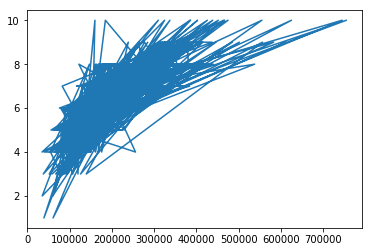

In [42]:
plt.plot(data["SalePrice"], data["OverallQual"])

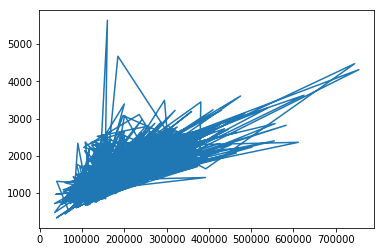

In [43]:
plt.plot(data["SalePrice"], data["GrLivArea"])

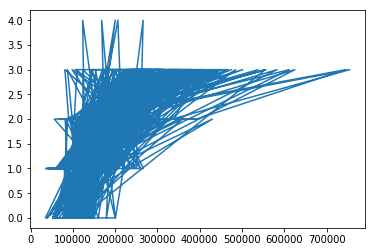

In [44]:
plt.plot(data["SalePrice"], data["GarageCars"])

(array([314.,   0., 329.,   0.,   0., 304.,   0., 338.,   0., 175.]),
 array([2006. , 2006.4, 2006.8, 2007.2, 2007.6, 2008. , 2008.4, 2008.8,
        2009.2, 2009.6, 2010. ]),
 <a list of 10 Patch objects>)

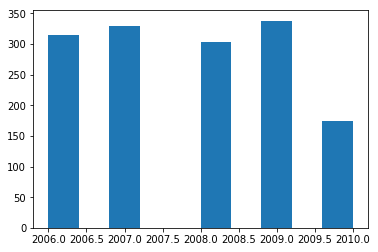

In [45]:
plt.hist(data["YrSold"])

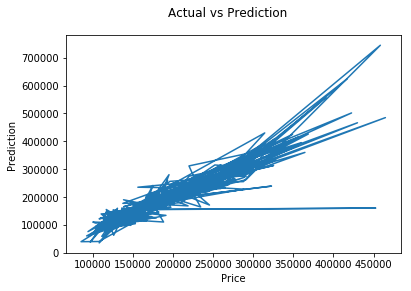

In [46]:
ndf = predictions.select("prediction", "SalePrice").toPandas()

plt.plot(ndf.prediction, ndf.SalePrice)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Actual vs Prediction")
plt.show()

Text(0.5,1,'Feature Importances')

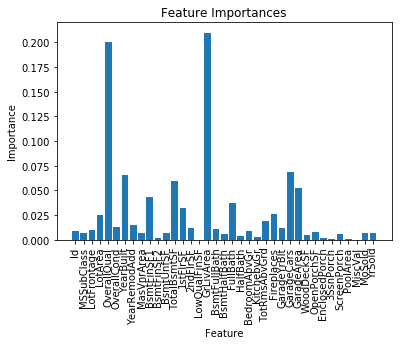

In [47]:
bestPipeline = cvmodel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, int_features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

# RE_ITERATION 1

In [48]:
R1_int_features = int_features

R1_int_features.remove("BsmtFinSF2")
R1_int_features.remove("EnclosedPorch")
R1_int_features.remove("3SsnPorch")
R1_int_features.remove("MiscVal")
R1_int_features.remove("PoolArea")

assembler = VectorAssembler(
    inputCols = R1_int_features,
    outputCol = "features")

output = assembler.transform(new_df)

Formatted_df = output.select("features","SalePrice")

In [49]:
(F_train_data, F_test_data) = Formatted_df.randomSplit([0.7, 0.3])

print((F_train_data.count(), len(F_train_data.columns)))

print((F_test_data.count(), len(F_test_data.columns)))

(991, 2)
(469, 2)


In [50]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(F_train_data)

rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='SalePrice')

pipeline = Pipeline(stages=[featureIndexer, rf])

RFmodel = pipeline.fit(F_train_data)

predictions = RFmodel.transform(F_test_data)

evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 28626.4


# RE-ITERATION 2

In [51]:
(F_train_data, F_test_data) = Formatted_df.randomSplit([0.8, 0.2])

print((F_train_data.count(), len(F_train_data.columns)))

print((F_test_data.count(), len(F_test_data.columns)))

(1177, 2)
(283, 2)


In [52]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(F_train_data)

rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol='SalePrice')

pipeline = Pipeline(stages=[featureIndexer, rf])

RFmodel = pipeline.fit(F_train_data)

predictions = RFmodel.transform(F_test_data)

evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 35614.8
